In [7]:
import os
import sys
sys.path.append("../../../sampler-comparison/src/inference-gym/spinoffs/inference_gym")
print(os.listdir("../../../../"))
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
import jax
num_cores = jax.local_device_count()
import inference_gym.using_jax as gym


import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
sys.path.append('./sampler-comparison')
sys.path.append('../../')
from sampler_comparison.samplers import samplers
import seaborn as sns

['probability', '.jupyter', 'blackjax-benchmarks', 'blackjax', '.python_history-56867.tmp', 'resultsGaussian_linear_1.01020.csv', '.ssh', '.config', '.pytensor', '.bash_history', '.udiRoot', 'slurm-32797052.out', '.zsh_history', '.local', '.ipynb_checkpoints', 'tensorflow_datasets', '.dotnet', 'app.sh', '.nv', 'gridresultsGaussian_linear_1.01020.csv', 'conf.py', '.zcompdump', '.wget-hsts', 'slurm-32796382.out', '.cursor-server', '.python_history-51829.tmp', '.cupy', 'results', 'test.py', '.python_history-82917.tmp', '.keras', 'startscript', 'containers', '.conda', 'eps_n_leap_1001100.npy', 'HMCLib', 'MicroCanonicalHMC', '.python_history', '.ipython', '.lesshst', '.netrc', '.viminfo', '.cache', '.bashrc', '.vscode-server', 'src']


# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

In [34]:
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
# from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian

model = IllConditionedGaussian(ndims=100, condition_number=1, eigenvalues='log', do_covariance=True)


samples, metadata = samplers['nuts'](return_samples=True)(
        model=model, 
        num_steps=100000,
        initial_position=jax.random.normal(jax.random.key(0), shape=(100,)), 
        key=jax.random.key(1))


In [46]:
samples = jax.random.normal(jax.random.key(2), shape=(100000, 100))

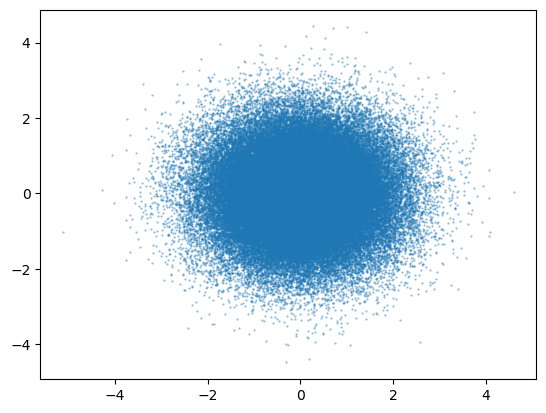

In [47]:
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, s=0.3)

In [48]:
from sampler_comparison.samplers.general import frobenius
from sampler_evaluation.evaluation.ess import samples_to_low_error

covs = jax.vmap(lambda x: jnp.outer(x,x))(samples)
# cov = jnp.mean(covs, axis=0)

running_covs = jnp.cumsum(covs, axis=0) / jnp.arange(1, samples.shape[0] + 1)[:, None, None]

true_cov = model.cov
running_b_cov = jax.vmap(lambda cov: frobenius(cov, true_cov))(running_covs)
# cov, true_cov

# frobenius(cov, true_cov)
samples_to_low_error(running_b_cov)*metadata["num_grads_per_proposal"].mean()


final error is 0.0010253137443214655


Array(107710.414, dtype=float32)

In [49]:
samples_to_low_error(running_b_cov)

final error is 0.0010253137443214655


Array(10288., dtype=float32, weak_type=True)